In [36]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel("wave number [1/cm]")
    plt.ylabel("Intensity")

## Traspoizione dei dati

In [3]:
#definisco i nomi da assegnare ai punti delli spettri di sampling
#wn -> wave number  r -> row c -> columns
names = ['wn']+[f'r{k}c{i}' for k in range(1,12) for i in range(1,12)]

In [4]:
# import dei "normalized data without offset"
data = pd.read_csv("../data/processed/data_normalized_without_offset.csv",names=names,skiprows=1)
# import dei dati senza rumore  ("nn" --> no noise)
data_nn = pd.read_csv("../data/processed/EDA_processed_data.csv",names=names,skiprows=1)

**Per poter usare il nostro algoritmo dobbiamo traspore il database, usare le lunghezze d'onda come features.**

Import dei dati processati, quelli dove abbiamo provato a rimuovere il rumore

In [5]:
data_nnt = data_nn.transpose()
new_header = data_nnt.iloc[0] #grab the first row for the header
data_nnt = data_nnt[1:]
data_nnt.columns = new_header #set the header row as the df header
data_nnt.head()

wn,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,192.0,193.0,...,1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,1248.0,1249.0
r1c1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r1c2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r1c3,0.0,0.0,0.0,0.0,0.0,0.000405,0.000539,0.000715,0.00077,0.000908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r1c4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r1c5,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Import dei dati normalizzati e senza offset, ma con rumore

In [6]:
data_t = data.transpose()
new_header = data_t.iloc[0] #grab the first row for the header
data_t = data_t[1:]
data_t.columns = new_header #set the header row as the df header
data_t.head()

wn,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,192.0,193.0,...,1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,1248.0,1249.0
r1c1,0.000122,0.000233,0.000247,0.000202,0.000015,-0.000092,-0.000235,-0.000359,-0.000355,-0.000359,...,-0.000121,0.000042,0.000070,0.000083,0.000047,-0.000019,-0.000164,-0.000233,-0.000186,0.000020
r1c2,-0.000049,-0.000053,-0.000060,-0.000074,-0.000101,-0.000116,-0.000137,-0.000162,-0.000174,-0.000179,...,-0.000252,-0.000203,-0.000206,-0.000214,-0.000226,-0.000232,-0.000233,-0.000232,-0.000234,-0.000220
r1c3,0.000013,0.000068,0.000095,0.000169,0.000338,0.000405,0.000539,0.000715,0.000770,0.000908,...,0.000143,0.000198,0.000157,0.000051,-0.000050,-0.000034,0.000043,0.000119,0.000150,0.000208
r1c4,-0.000187,0.000087,0.000141,0.000141,-0.000003,-0.000106,-0.000230,-0.000318,-0.000293,-0.000203,...,-0.000229,-0.000235,-0.000208,-0.000156,-0.000116,-0.000137,-0.000199,-0.000231,-0.000208,-0.000131
r1c5,-0.000671,-0.000473,-0.000425,-0.000353,-0.000251,-0.000247,-0.000232,-0.000217,-0.000233,-0.000222,...,-0.000008,-0.000107,-0.000135,-0.000169,-0.000170,-0.000122,-0.000004,0.000067,0.000050,-0.000035


## Prova di clustering con DBSCAN

### Clustering dei dati rumorosi

In [7]:
cluster_DB = DBSCAN(eps=0.025, min_samples=2)
cluster_DB.fit(data_t)
label = cluster_DB.labels_

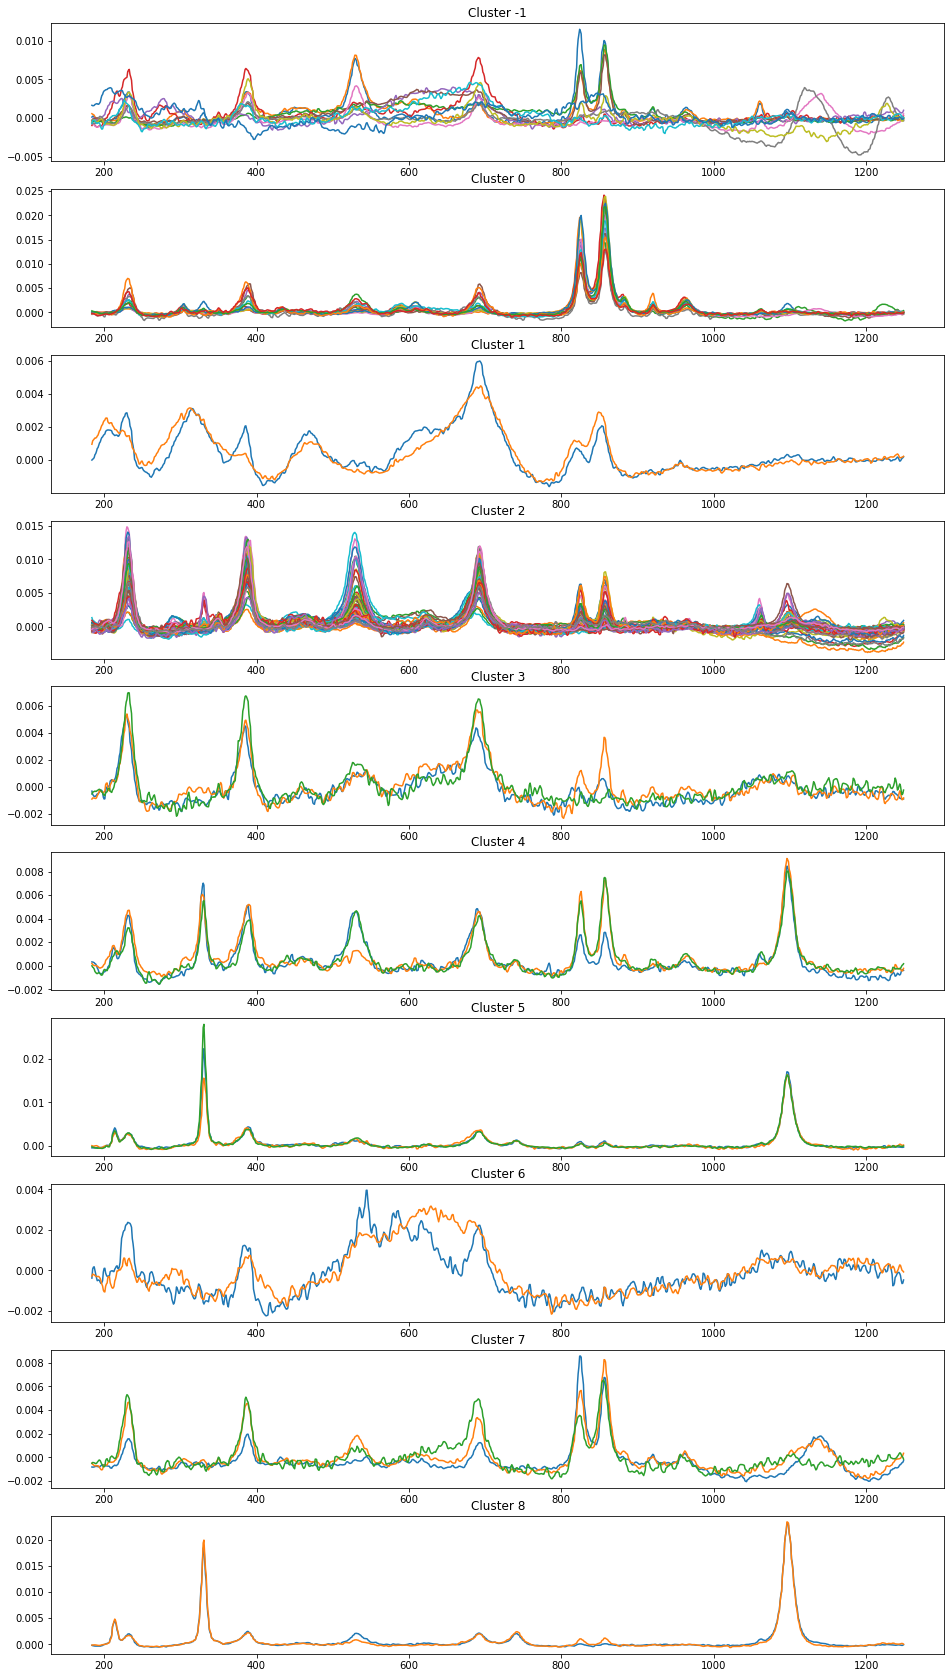

In [8]:
fig, axs = plt.subplots(len(np.unique(label)),figsize = (16,30))
#fig.suptitle("Plot dei vari cluster, asse x: numero d'onda. asse y: intensita'")
for i in enumerate(np.unique(label)):
    for temp in enumerate(label):
        if temp[1]==i[1]:
            axs[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs[i[0]].set_title('Cluster ' + str(i[1]))

### Clustering dei dati a cui e' stato tolto il rumore

I plot sono comunque fatti con gli spettri rumorosi, altrimenti non si capisce nulla

In [9]:
cluster_nn_DB = DBSCAN(eps=0.020, min_samples=3)
cluster_nn_DB.fit(data_nnt)
label_nn = cluster_nn_DB.labels_

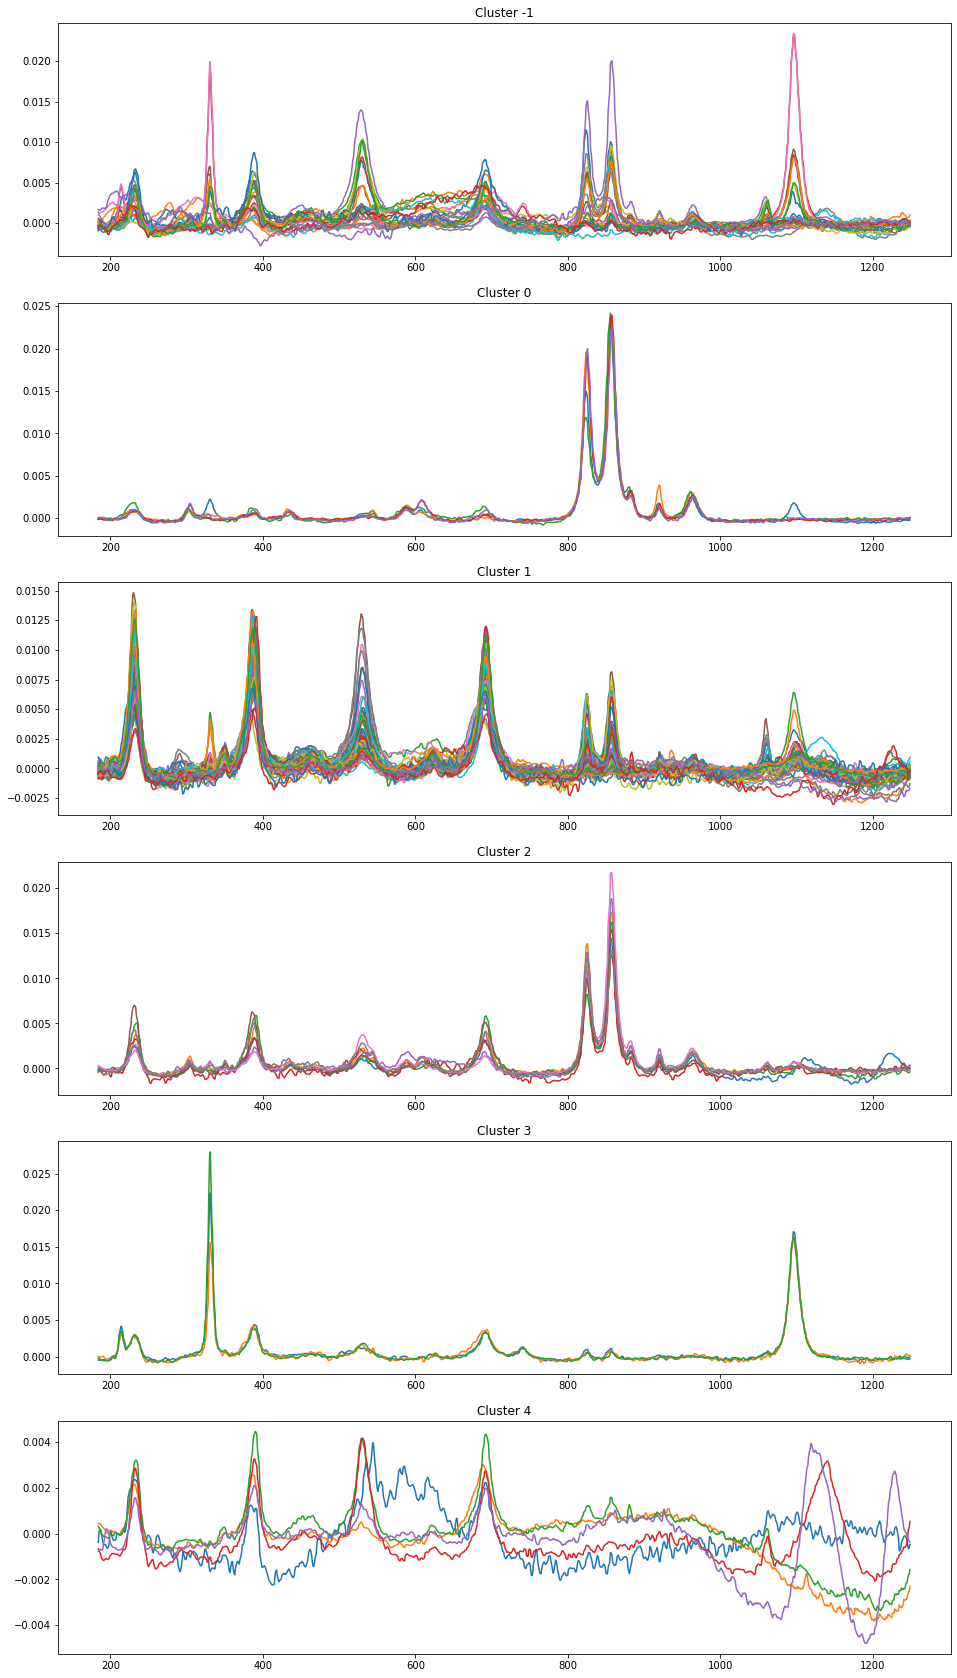

In [10]:
fig2, axs2 = plt.subplots(len(np.unique(label_nn)),figsize = (16,30))
#fig.suptitle("Plot dei vari cluster, asse x: numero d'onda. asse y: intensita'")
for i in enumerate(np.unique(label_nn)):
    for temp in enumerate(label_nn):
        if temp[1]==i[1]:
            axs2[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs2[i[0]].set_title('Cluster ' + str(i[1]))

## Prova di clustering con OPTICS

In [11]:
cluster_nn_OP = OPTICS(min_samples=2, xi=.05, min_cluster_size=.03)
cluster_nn_OP.fit(data_nnt)
label_nn = cluster_nn_OP.labels_

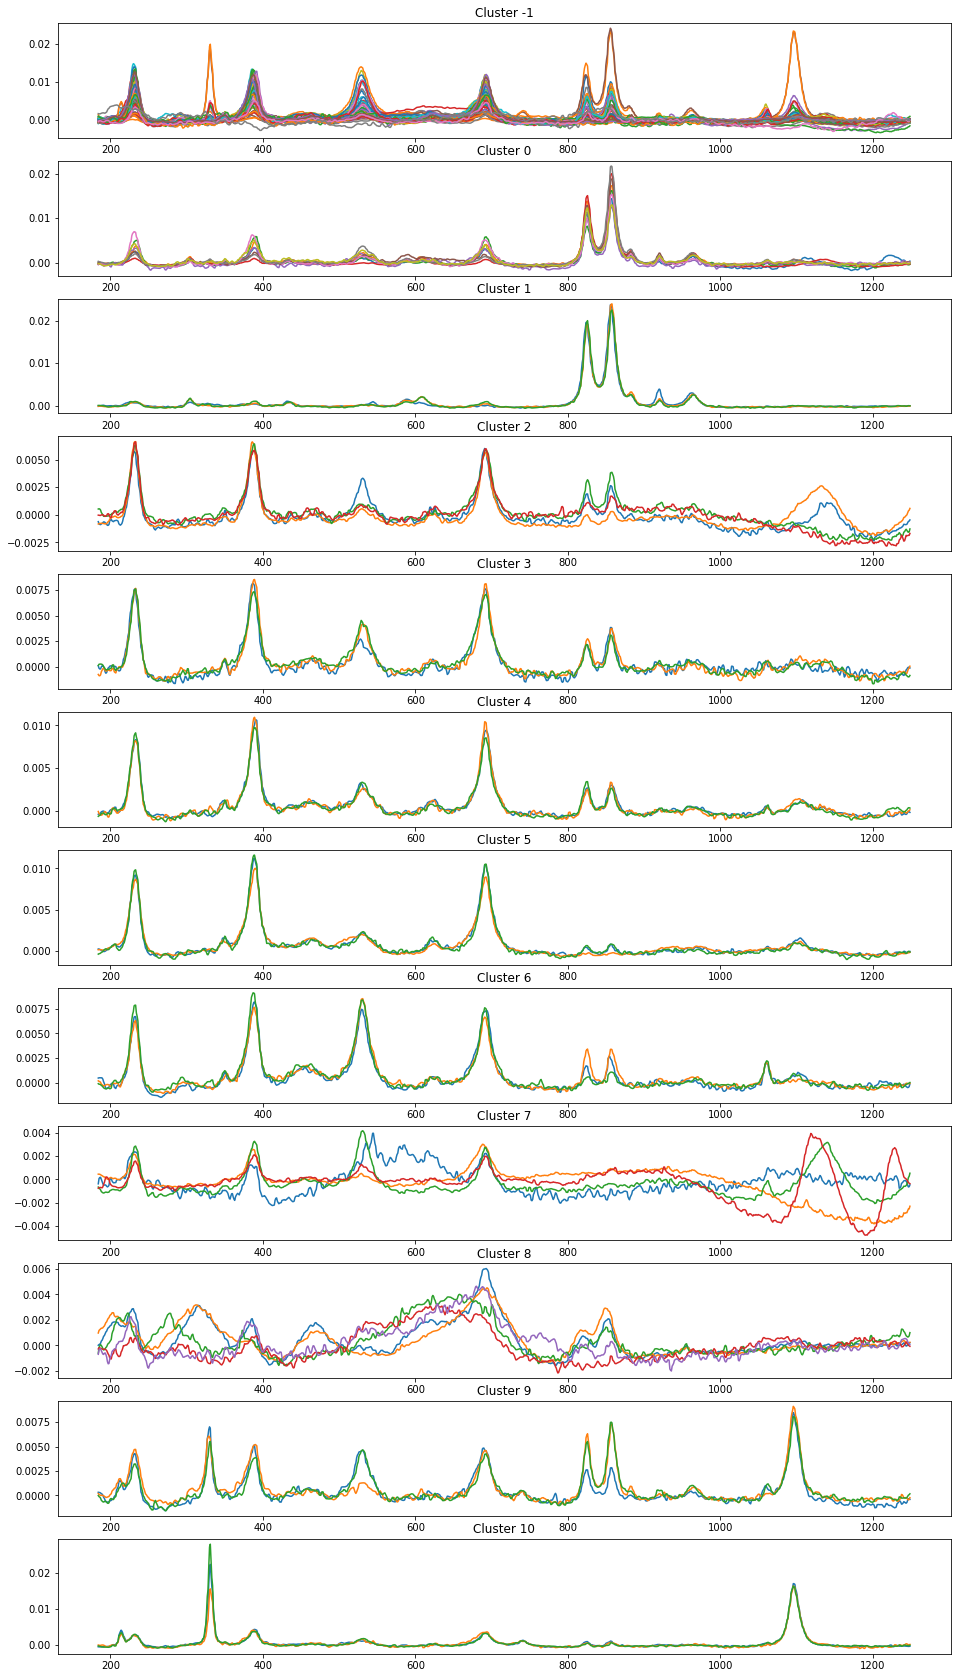

In [12]:
fig2, axs2 = plt.subplots(len(np.unique(label_nn)),figsize = (16,30))
#fig.suptitle("Plot dei vari cluster, asse x: numero d'onda. asse y: intensita'")
for i in enumerate(np.unique(label_nn)):
    for temp in enumerate(label_nn):
        if temp[1]==i[1]:
            axs2[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs2[i[0]].set_title('Cluster ' + str(i[1]))

## Prova di clustering con KMEANS

In [44]:
cluster_t_KM = KMeans(n_clusters=5,max_iter=600,tol=0.000001)
cluster_t_KM.fit(data_t)
label_t = cluster_t_KM.labels_

### Heat map

Facciamo un plot per vedere se i cluster trovati correlano con la posizione

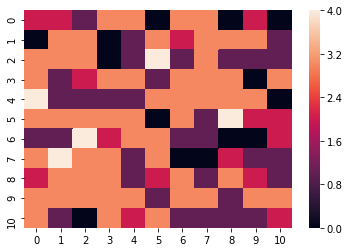

In [47]:
temp = []
for i in enumerate(np.linspace(start=11,stop=121,num=11,dtype=int)):
    temp.append(label_t[i[1]-11:i[1]])
label_grid = np.array(temp)
sns.heatmap(label_grid);

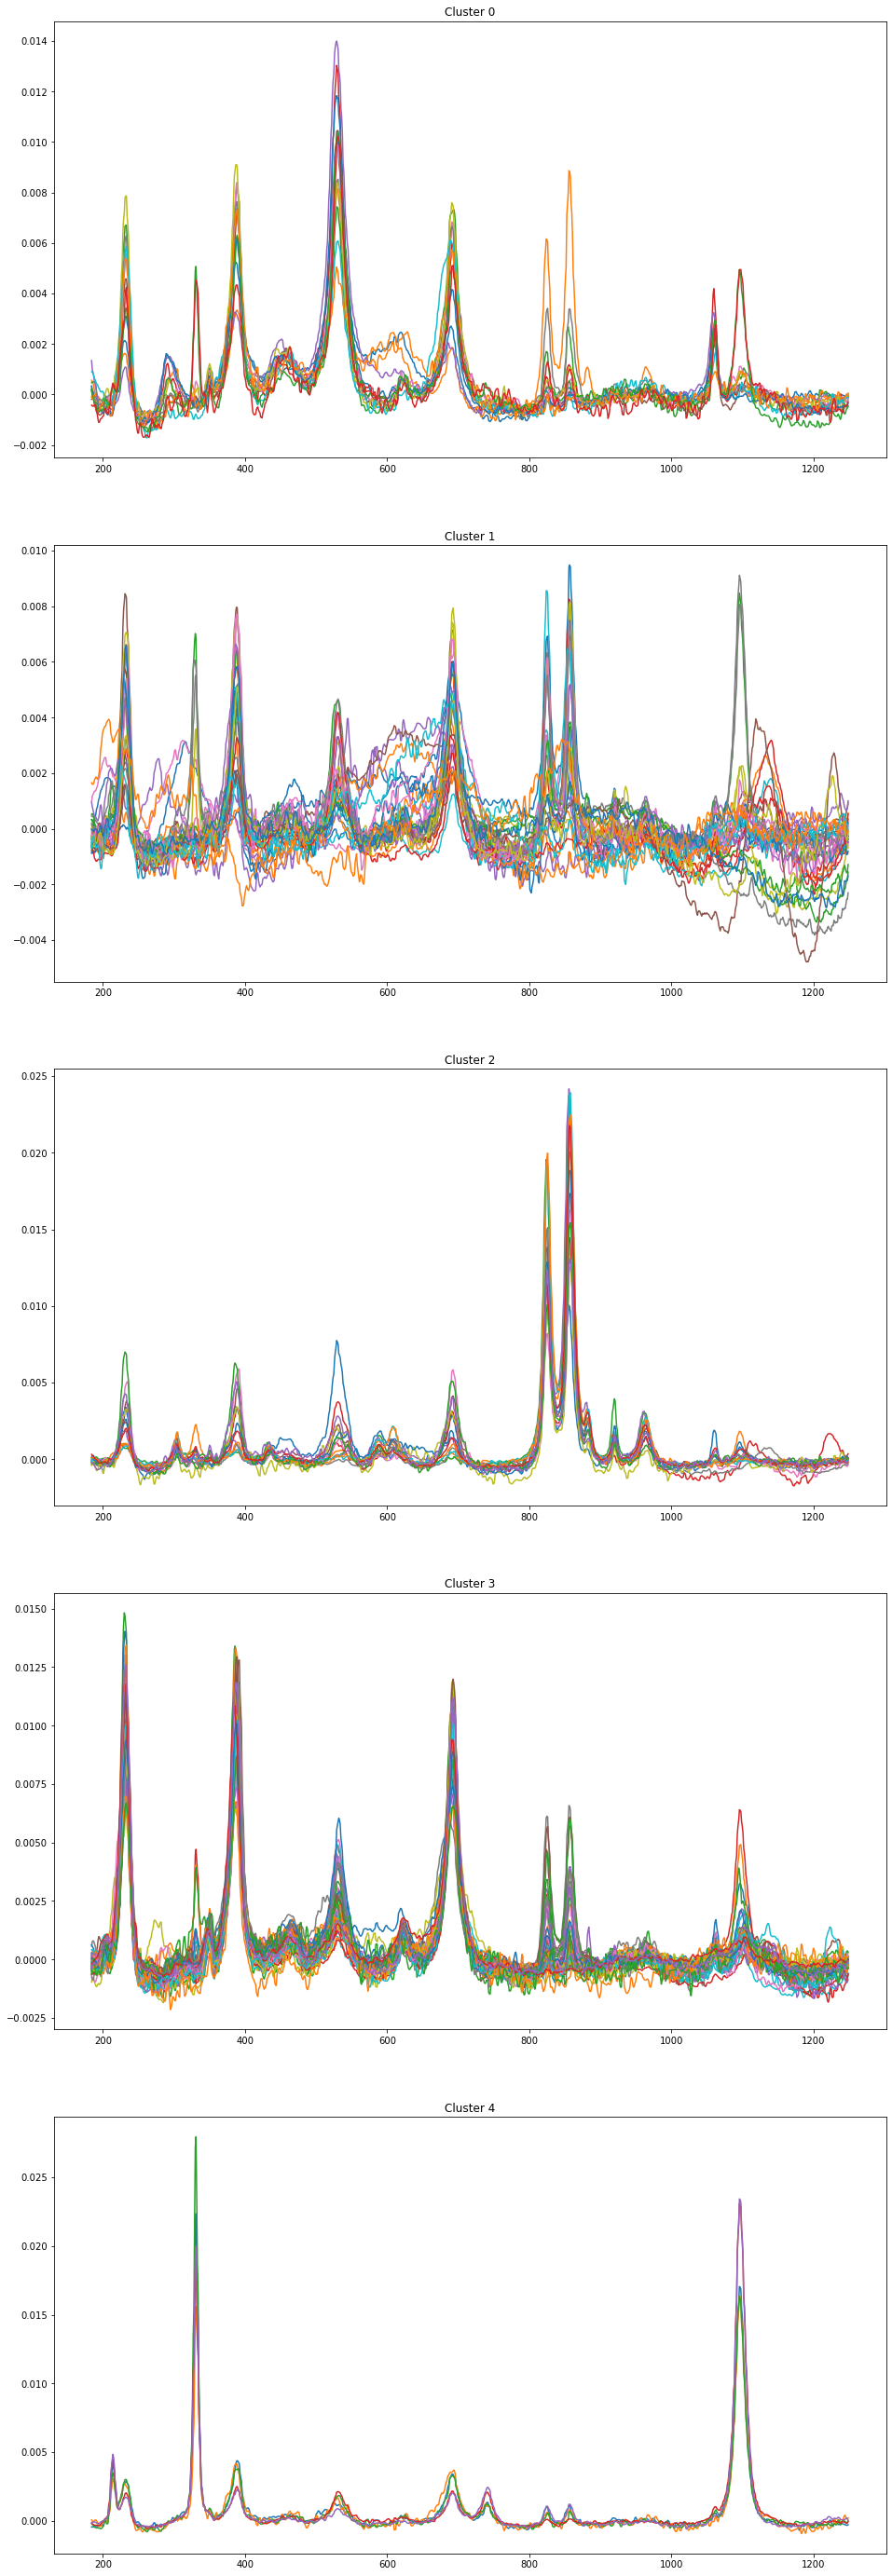

In [46]:
fig2, axs2 = plt.subplots(len(np.unique(label_t)),figsize = (16,50))
#fig.suptitle("Plot dei vari cluster, asse x: numero d'onda. asse y: intensita'")
for i in enumerate(np.unique(label_t)):
    for temp in enumerate(label_t):
        if temp[1]==i[1]:
            axs2[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs2[i[0]].set_title('Cluster ' + str(i[1]))
            